In [1]:
import random
import math
import time
import copy
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
random.seed(time.time()) #To get a "really" random generator 

In [3]:
class Cell (object) :
    
    next_ID = 0
    
    def __init__(self, state = "NORMAL", clone = 0, fitness = 1, mutation_rate = 0.001):
        self.state = state
        self.fitness = fitness
        self.clone = clone
        self.mutation_rate = mutation_rate
        self.ID = Cell.next_ID
        self.get_cure = False
        self.treatment_duration = 0
        Cell.next_ID += 1
        
    def __str__(self):
        return "Cell #{0} of state : {1} and clone type {2}".format(self.ID, self.state, self.clone)
    
    def mutate (self, new_clone_id):
        if self.state == "NORMAL":
            self.state = "CANCEROUS"
            
        self.clone = new_clone_id
        self.fitness = round(random.uniform(0,2), 3)
        self.mutation_rate = round(random.uniform(0, 0.02), 4)
        
    def treatment (self, alpha):
        self.get_cure == True
        self.fitness = self.fitness * alpha
        self.treatment_duration += 1

In [4]:
class Tissue ( object ) :
    
    def __init__(self, omega, alpha, generation_time, clones_init):
        self.generation_time = generation_time
        self.omega = omega
        self.alpha = alpha
        self.cancer_detection = False
        self.current_cure = None
        self.pop = []
        self.clones_pop = copy.deepcopy(clones_init)    
    
    def initial_population(self, N = 1000, prop_cancer = 0.01):
        
        nb_cancer_cells = round(prop_cancer *N)
        
        for i in range(N):
            if (i < nb_cancer_cells) :
                state = "CANCEROUS"
                clone = random.choice(range(1, len(self.clones_pop.keys())))
                
            else :
                state = "NORMAL"
                clone = 0
            
            fitness = self.clones_pop[clone]["fitness"]
            mutation_rate = self.clones_pop[clone]["mu"]  
                
            new_cell = Cell(state, clone, fitness, mutation_rate)
            self.pop.append(new_cell)
            self.clones_pop[clone]["freq"] += 1 
            
    def stats(self):
        nb_cells = len(self.pop)
        nb_normal_cells = self.clones_pop[0]["freq"]
        nb_cancer_cells = nb_cells - nb_normal_cells
        nb_clones = 0
        
        average_fitness = sum([cell.fitness for cell in self.pop])/(nb_cells)
        
        for key in list(self.clones_pop.keys()):
            if (key != 0 and self.clones_pop[key]["freq"] > 0):
                nb_clones +=1
        
        if (nb_cancer_cells >= self.omega * nb_cells):
            self.cancer_detection = True
        else:
            self.cancer_detection = False
 
        return (nb_cells, nb_normal_cells, nb_cancer_cells, nb_clones, average_fitness)
            
    def targeted_treatment(self, n=5):
        
        if (n>len(self.clones_pop)) :
            n = len(self.clones_pop) -1
        
        # if the cancer has been detected and no cure in progress
        if (self.cancer_detection == True and self.current_cure == None):
            
            # find the biggest colonie of mutant clone to treat in prority
            self.current_cure = [clones[0] for clones in sorted({k:self.clones_pop[k] for k in self.clones_pop if k!=0}.items(), 
                                   key=lambda item: item[1]["freq"], 
                                   reverse=True)[:n]]
            
            for cell in self.pop:
                if (cell.clone in self.current_cure):
                    cell.treatment_duration = 0
                    cell.treatment(self.alpha)
                    
        # if there is already a cure on specific clone in progress, just continue it until the end of generation time                
        if(self.current_cure != None):
            remaining_cells_to_treat = 0
            for cell in self.pop:
                if(cell.clone in self.current_cure and cell.treatment_duration < self.generation_time):
                    cell.treatment(self.alpha)
                    remaining_cells_to_treat += 1
            
            if (remaining_cells_to_treat == 0):
                self.current_cure = None
                for cell in self.pop:
                    cell.get_cure == False
                    cell.treatment_duration = 0
                        
    
    def reproduce (self):
    
        candidat = random.choices(self.pop, weights=[c.fitness for c in self.pop], k=1)[0]
        new_cell = Cell(candidat.state, candidat.clone, candidat.fitness, candidat.mutation_rate)
        
        
        #Proba of mutation : give birth to a new clone type
        proba_mutation = random.uniform(0, 1) 
        if proba_mutation < new_cell.mutation_rate :
            new_clone_id=len(self.clones_pop.keys())
            new_cell.mutate(new_clone_id)
            self.clones_pop[new_cell.clone] = self.clones_pop.get(new_cell.clone, {"fitness" :new_cell.fitness, 
                                         "mu": new_cell.mutation_rate, 
                                        "freq" : 1})
        else:
            self.clones_pop[new_cell.clone]["freq"] += 1
        
        self.pop.append(new_cell)
    
    def get_apoptose(self, weighted = True):
        if (weighted):
            cell = random.choices(self.pop, weights=[1/(c.fitness+0.01) for c in self.pop], k=1)[0]
        else:
            cell = random.choice(self.pop)
            
        self.pop.remove(cell)
        self.clones_pop[cell.clone]["freq"] -= 1 

In [5]:
default_clone_init = {0: {"fitness" : 1,"mu": 0.001, "freq" : 0}}

def run (nb_runs=10000, N=1000, prop_cancer=0.1, omega=0.2, alpha=0.5, T=20, treatment = True, nb_treatments = 5, verbose = True, weighted_apoptosis = True, clones_init=default_clone_init):
    
    my_tissue = Tissue(omega, alpha, T, clones_init=clones_init)
    my_tissue.initial_population(N, prop_cancer)  #initial population of 1000 individus
    
    if verbose:
        print("Initilisation : ")
        print ( "Total number of cells : {}, number of normal cells : {}, number of cancerous cells {}".format(my_tissue.stats()[0], my_tissue.stats()[1], my_tissue.stats()[2]) ) 
        print ( "\n" )
        
    nb_cells = []
    nb_normal_cells = []
    nb_cancer_cells = []
    nb_clones = []
    averages_fitness = []
    
    for i in range (nb_runs):
        #random.seed(time.time())
        my_tissue.reproduce()
        my_tissue.get_apoptose(weighted_apoptosis)
        
        if (treatment) :
            my_tissue.targeted_treatment(n=nb_treatments)
        
        nb_cells.append(my_tissue.stats()[0])
        nb_normal_cells.append(my_tissue.stats()[1])
        nb_cancer_cells.append(my_tissue.stats()[2])
        nb_clones.append(my_tissue.stats()[3])        
        averages_fitness.append(my_tissue.stats()[4])
        
    if verbose :
        print ( "Statistics after", nb_runs, "runs : ")
        print ( "Total number of cells : {}, number of normal cells : {}, number of cancerous cells : {}".format(nb_cells[-1], nb_normal_cells[-1], nb_cancer_cells[-1], "\n" ) )
        #print ("\n")
        #print(my_tissue.clones_pop)
        
    return ( (nb_cells, nb_normal_cells, nb_cancer_cells, nb_clones, averages_fitness))
    #return (my_tissue.pop)

In [6]:
nb_init_clones = 3
clones_init = {0: {"fitness" : 1,"mu": 0.001, "freq" : 0}}

for i in range(1,nb_init_clones+1):
    clones_init[i] = clones_init.get(i, {"fitness" :round(random.uniform(0,2), 3), 
                                         "mu": round(random.uniform(0, 0.02), 4), 
                                        "freq" : 0})

In [7]:
#Without treatment :
simulation1 = run(nb_runs=10000, N=2000, prop_cancer= 0.1, treatment=False, verbose=True, clones_init=clones_init)

Initilisation : 
Total number of cells : 2000, number of normal cells : 1800, number of cancerous cells 200


Statistics after 10000 runs : 
Total number of cells : 2000, number of normal cells : 337, number of cancerous cells : 1663


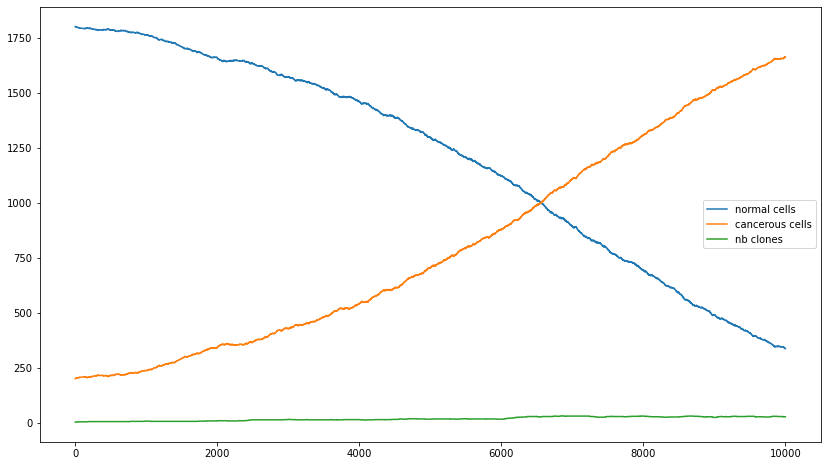

In [8]:
plt.figure(figsize=(14, 8))
plt.plot(range(10000), simulation1[1], label = "normal cells")
plt.plot(range(10000), simulation1[2], label = "cancerous cells")
plt.plot(range(10000), simulation1[3], label = "nb clones")
plt.legend()
plt.show()

In [9]:
#With treatment :
simulation2 = run (nb_runs=10000, N=2000, prop_cancer=0.1, omega=0.25, alpha=0.5, T=10, treatment=True, nb_treatments=2, verbose=True, weighted_apoptosis = True, clones_init=clones_init)

Initilisation : 
Total number of cells : 2000, number of normal cells : 1800, number of cancerous cells 200


Statistics after 10000 runs : 
Total number of cells : 2000, number of normal cells : 1623, number of cancerous cells : 377


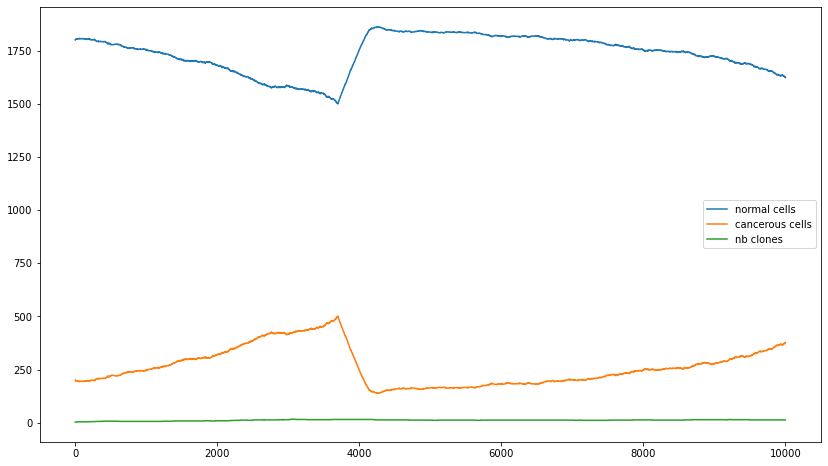

In [10]:
plt.figure(figsize=(14, 8))
plt.plot(range(10000), simulation2[1], label = "normal cells")
plt.plot(range(10000), simulation2[2], label = "cancerous cells")
plt.plot(range(10000), simulation2[3], label = "nb clones")
plt.legend()
plt.show()

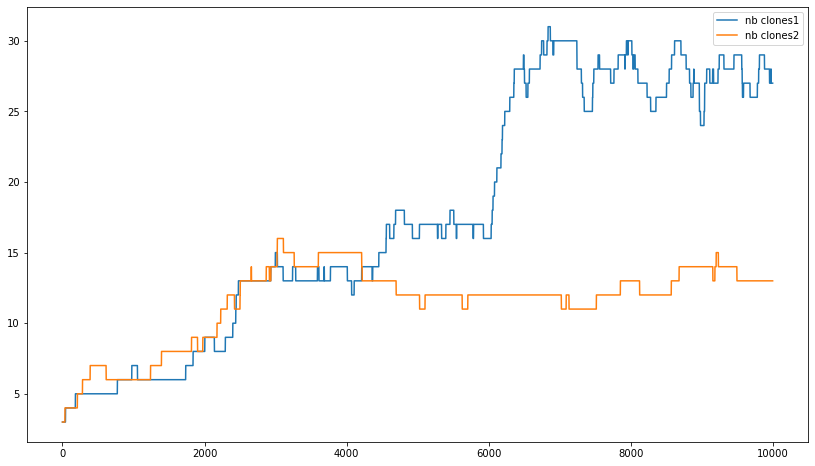

In [11]:
plt.figure(figsize=(14, 8))
plt.plot(range(10000), simulation1[3], label = "nb clones1")
plt.plot(range(10000), simulation2[3], label = "nb clones2")
plt.legend()
plt.show()

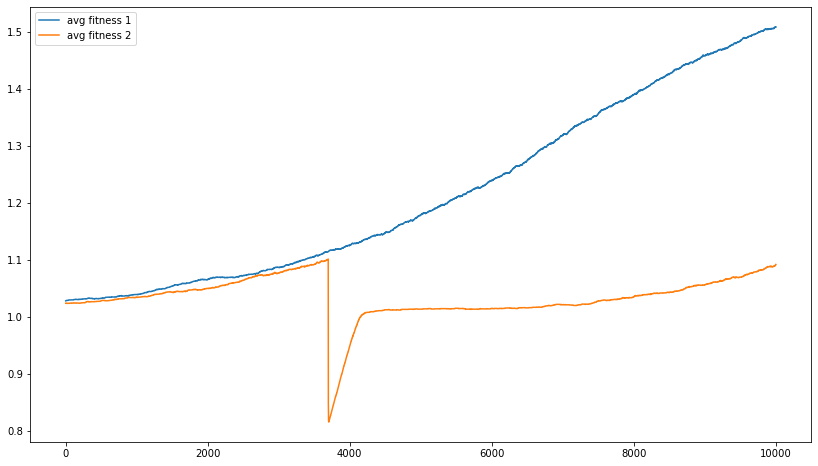

In [12]:
plt.figure(figsize=(14, 8))
plt.plot(range(10000), simulation1[4], label = "avg fitness 1")
plt.plot(range(10000), simulation2[4], label = "avg fitness 2")
plt.legend()
plt.show()

In [13]:
def shannon_diversity (N, n):
    p = n/N
    return (- p *  math.log(p, 2)) #napierian logarithm

In [14]:
shannon_diversity (1000, simulation1[2][-1]) #without treatment

-1.2202897244236777

In [15]:
shannon_diversity (1000, simulation2[2][-1]) #with treatment

0.5305760664153204